In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from pathlib import Path

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms

from utils import mnist, plot_graphs, plot_mnist
import numpy as np

%matplotlib inline

In [3]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print('Device:', device)

Device: cuda:0


In [4]:
DATA_PATH = Path('./data/')

In [5]:
mnist_transform = transforms.Compose([
                transforms.ToTensor(),
                transforms.Normalize((0.5,), (0.5,)),
           ])
train_loader, valid_loader, test_loader = mnist(valid=10000, transform=mnist_transform, path=DATA_PATH/'MNIST_data')

In [6]:
class Encoder(nn.Module):
    def __init__(self, latent_size=10):
        super(Encoder, self).__init__()
        self.fc1 = nn.Linear(28*28, latent_size)
    
    def forward(self, x):
        x = torch.sigmoid(self.fc1(x))
        return x
    
class Decoder(nn.Module):
    def __init__(self, latent_size=10):
        super(Decoder, self).__init__()
        self.fc1 = nn.Linear(latent_size, 28*28)
    
    def forward(self, x):
        x = torch.tanh(self.fc1(x))
        return x

In [9]:
# NN with updated KL divergence formula

class Net(nn.Module):
    def __init__(self, latent_size=10, loss_fn=F.mse_loss, lr=1e-4, l2=0.):
        super(Net, self).__init__()
        self.latent_size = latent_size
        self.E = Encoder(latent_size)
        self.D = Decoder(latent_size)
        self.loss_fn = loss_fn
        self._rho_loss = None
        self._loss = None
        self.optim = optim.Adam(self.parameters(), lr=lr, weight_decay=l2)
        
    def forward(self, x):
        x = x.view(-1, 28*28)
        h = self.E(x)
        self.data_rho = h.mean(0)
        out = self.D(h)
        return out
    
    def decode(self, h):
        with torch.no_grad():
            return self.D(h)
    
    def rho_loss(self, rho, size_average=True):
        """
        D_KL(P||Q) = sum(p*log(p/q)) = -sum(p*log(q/p)) = -p*log(q/p) - (1-p)log((1-q)/(1-p))
        """
        # dkl = - torch.log(self.data_rho/rho) * rho - torch.log((1-self.data_rho)/(1-rho)) * (1-rho)
        dkl = - torch.log(self.data_rho) * rho - torch.log(1 - self.data_rho) * (1 - rho)

        if size_average:
            self._rho_loss = dkl.mean()
        else:
            self._rho_loss = dkl.sum()
        return self._rho_loss
    
    def loss(self, x, target, **kwargs):
        target = target.view(-1, 28*28)
        self._loss = self.loss_fn(x, target, **kwargs)
        return self._loss

In [11]:
def train(epoch, models, log=None):
    train_size = len(train_loader.sampler)
    for batch_idx, (data, _) in enumerate(train_loader):
        data = data.to(device)
        
        for model in models.values():
            model.optim.zero_grad()
            output = model(data)
            rho_loss = model.rho_loss(rho)
            loss = model.loss(output, data) + rho_loss
            loss.backward()
            model.optim.step()
            
        if batch_idx % 200 == 0:
            line = 'Train Epoch: {} [{}/{} ({:.0f}%)]\tLosses '.format(
                epoch, batch_idx * len(data), train_size, 100. * batch_idx / len(train_loader))
            losses = ' '.join(['{}: {:.6f}'.format(k, m._loss.item()) for k, m in models.items()])
            print(line + losses)
            
    else:
        batch_idx += 1
        line = 'Train Epoch: {} [{}/{} ({:.0f}%)]\tLosses '.format(
            epoch, batch_idx * len(data), train_size, 100. * batch_idx / len(train_loader))
        losses = ' '.join(['{}: {:.6f}'.format(k, m._loss.item()) for k, m in models.items()])
        if log is not None:
            for k in models:
                log[k].append((models[k]._loss, models[k]._rho_loss))
        print(line + losses)

In [12]:
avg_lambda = lambda l: 'loss: {:.4f}'.format(l)
rho_lambda = lambda p: 'rho_loss: {:.4f}'.format(p)
line = lambda i, l, p: '{}: '.format(i) + avg_lambda(l) + '\t' + rho_lambda(p)
    
def test(models, loader, log=None):
    test_size = len(loader.sampler)

    test_loss = {k: 0. for k in models}
    rho_loss = {k: 0. for k in models}
    with torch.no_grad():
        for data, _ in loader:
            data = data.to(device)
            output = {k: m(data) for k, m in models.items()}
            
            for k, m in models.items():
                test_loss[k] += m.loss(output[k], data, reduction='sum').item() # sum up batch loss
                rho_loss[k] += m.rho_loss(rho, size_average=False).item()
    
    for k in models:
        test_loss[k] /= (test_size * 784)
        rho_loss[k] /= (test_size * models[k].latent_size)
        if log is not None:
            log[k].append((test_loss[k], rho_loss[k]))
    
    lines = '\n'.join([line(k, test_loss[k], rho_loss[k]) for k in models]) + '\n'
    report = 'Test set:\n' + lines        
    print(report)

In [13]:
models = {'16': Net(16).to(device), '32': Net(32).to(device), '64': Net(64).to(device)}
rho = 0.05
train_log = {k: [] for k in models}
test_log = {k: [] for k in models}

for epoch in range(1, 21):
    for model in models.values():
        model.train()
    train(epoch, models, train_log)
    for model in models.values():
        model.eval()
    test(models, valid_loader, test_log)

Train Epoch: 1 [0/50000 (0%)]	Losses 16: 1.020332 32: 1.023490 64: 0.997515
Train Epoch: 1 [10000/50000 (20%)]	Losses 16: 0.897234 32: 0.872942 64: 0.710185
Train Epoch: 1 [20000/50000 (40%)]	Losses 16: 0.849483 32: 0.704710 64: 0.432802
Train Epoch: 1 [30000/50000 (60%)]	Losses 16: 0.766323 32: 0.537401 64: 0.376385
Train Epoch: 1 [40000/50000 (80%)]	Losses 16: 0.652863 32: 0.433380 64: 0.320568
Train Epoch: 1 [50000/50000 (100%)]	Losses 16: 0.566342 32: 0.401932 64: 0.310731
Test set:
16: loss: 0.5538	rho_loss: 0.0058
32: loss: 0.3827	rho_loss: 0.0063
64: loss: 0.2889	rho_loss: 0.0059

Train Epoch: 2 [0/50000 (0%)]	Losses 16: 0.563898 32: 0.400110 64: 0.307970
Train Epoch: 2 [10000/50000 (20%)]	Losses 16: 0.488937 32: 0.351424 64: 0.269671
Train Epoch: 2 [20000/50000 (40%)]	Losses 16: 0.461920 32: 0.343281 64: 0.264304
Train Epoch: 2 [30000/50000 (60%)]	Losses 16: 0.391729 32: 0.290883 64: 0.227819
Train Epoch: 2 [40000/50000 (80%)]	Losses 16: 0.373506 32: 0.285329 64: 0.219375
Train

In [14]:
with torch.no_grad():
    data, _ = next(iter(test_loader))
    print(data.shape)
    data = data.to(device)
    
    # original data
    output = models['64'](data)
    to_plot = output.view(-1, 1, 28, 28).clamp(0, 1).data.cpu().numpy()
    
    # decoded eye matrix
    decoded = models['64'].decode(torch.eye(64).to(device))
    print(decoded.shape)
    dec_to_plot = ((decoded.view(-1, 1, 28, 28) + 1) * 0.5).clamp(0, 1).data.cpu().numpy()
    
    # encoded data with only neurons where activations > 0.5
    encoded = models['64'].E(data.view(-1, 28*28))
    print(encoded.shape)
    print((encoded > 0.5).sum(1))
    encoded[encoded < 0.5] = 0.
    
    # decoded data from previous step
    decoded_f = models['64'].decode(encoded)
    print(decoded_f.shape)
    f_to_plot = ((decoded_f.view(-1, 1, 28, 28) + 1) * 0.5).clamp(0, 1).data.cpu().numpy()

torch.Size([50, 1, 28, 28])
torch.Size([64, 784])
torch.Size([50, 64])
tensor([4, 5, 2, 4, 2, 3, 4, 3, 2, 3, 5, 5, 2, 2, 3, 4, 1, 4, 3, 1, 3, 3, 4, 4,
        2, 4, 2, 3, 4, 3, 4, 4, 5, 2, 4, 3, 1, 3, 1, 2, 2, 3, 3, 2, 3, 3, 4, 1,
        4, 2], device='cuda:0')
torch.Size([50, 784])


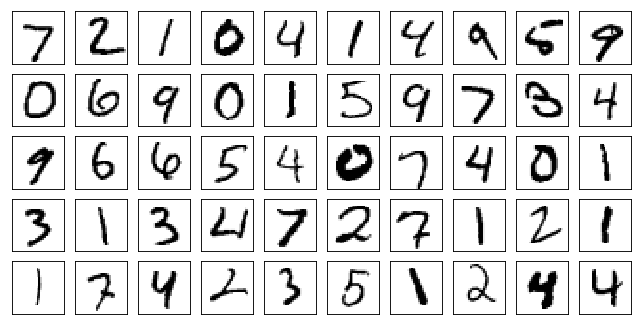

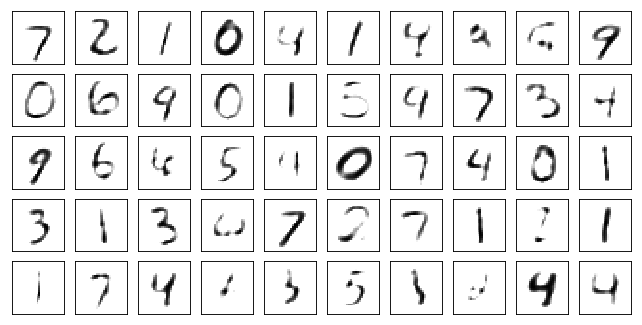

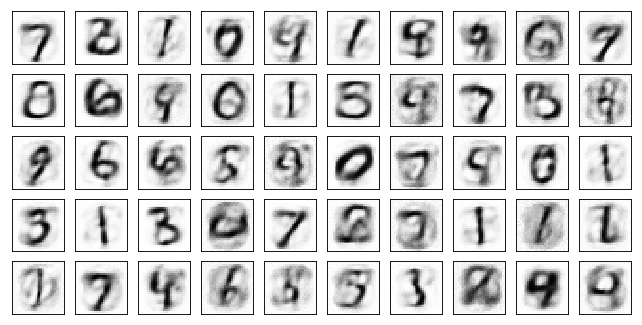

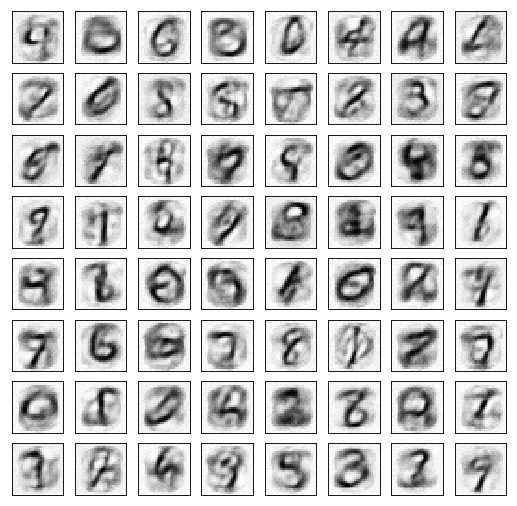

In [15]:
plot_mnist(data.data.cpu().numpy(), (5, 10))
plot_mnist(to_plot, (5, 10))
plot_mnist(f_to_plot, (5, 10))
plot_mnist(dec_to_plot, (8, 8))

**Conclusion**
 - We have nearly the same quality of the digits in the plots after updating KL divergence formula
 - beta parameter can be added for controlling tradeof between the loss and KL penalty term

In [60]:
class Encoder2(nn.Module):
    def __init__(self, latent_size=10):
        super(Encoder2, self).__init__()
        self.fc1 = nn.Linear(28*28, latent_size)
    
    def forward(self, x):
#         x = torch.sigmoid(self.fc1(x))
        x = torch.tanh(self.fc1(x))
        return x
    
class Decoder2(nn.Module):
    def __init__(self, latent_size=10):
        super(Decoder2, self).__init__()
        self.fc1 = nn.Linear(latent_size, 28*28)
    
    def forward(self, x):
        x = torch.tanh(self.fc1(x))
        return x

In [61]:
# NN with sigmoid activation and rho_loss based on L1

class Net2(nn.Module):
    def __init__(self, latent_size=10, loss_fn=F.mse_loss, lr=1e-4, l2=0.):
        super(Net2, self).__init__()
        self.latent_size = latent_size
        self.E = Encoder2(latent_size)
        self.D = Decoder2(latent_size)
        self.loss_fn = loss_fn
        self._rho_loss = None
        self._loss = None
        self.optim = optim.Adam(self.parameters(), lr=lr, weight_decay=l2)
        
    def forward(self, x):
        x = x.view(-1, 28*28)
        h = self.E(x)
        self.data_rho = h.mean(0)
        out = self.D(h)
        return out
    
    def decode(self, h):
        with torch.no_grad():
            return self.D(h)
    
    def rho_loss(self, rho, size_average=True):
        """
        D_KL(P||Q) = sum(p*log(p/q)) = -sum(p*log(q/p)) = -p*log(q/p) - (1-p)log((1-q)/(1-p))
        """
        
        l1 = torch.abs(self.data_rho - rho)
            
        if size_average:
            self._rho_loss = l1.mean()
        else:
            self._rho_loss = l1.sum()
                    
        return self._rho_loss
    
    def loss(self, x, target, **kwargs):
        target = target.view(-1, 28*28)
        self._loss = self.loss_fn(x, target, **kwargs)
        return self._loss

In [62]:
models_2 = {'16': Net2(16).to(device), '32': Net2(32).to(device), '64': Net2(64).to(device)}
rho = 0.05
train_log = {k: [] for k in models}
test_log = {k: [] for k in models}

for epoch in range(1, 21):
    for model in models_2.values():
        model.train()
    train(epoch, models_2, train_log)
    for model in models_2.values():
        model.eval()
    test(models_2, valid_loader, test_log)

Train Epoch: 1 [0/50000 (0%)]	Losses 16: 0.986015 32: 1.014608 64: 0.986534
Train Epoch: 1 [10000/50000 (20%)]	Losses 16: 0.915657 32: 0.872850 64: 0.622128
Train Epoch: 1 [20000/50000 (40%)]	Losses 16: 0.850990 32: 0.606058 64: 0.359991
Train Epoch: 1 [30000/50000 (60%)]	Losses 16: 0.744508 32: 0.406193 64: 0.276616
Train Epoch: 1 [40000/50000 (80%)]	Losses 16: 0.590864 32: 0.352116 64: 0.243659
Train Epoch: 1 [50000/50000 (100%)]	Losses 16: 0.480479 32: 0.317195 64: 0.225465
Test set:
16: loss: 0.4827	rho_loss: 0.0036
32: loss: 0.3158	rho_loss: 0.0038
64: loss: 0.2283	rho_loss: 0.0031

Train Epoch: 2 [0/50000 (0%)]	Losses 16: 0.485165 32: 0.317868 64: 0.228252
Train Epoch: 2 [10000/50000 (20%)]	Losses 16: 0.429593 32: 0.295604 64: 0.208848
Train Epoch: 2 [20000/50000 (40%)]	Losses 16: 0.364718 32: 0.259606 64: 0.189900
Train Epoch: 2 [30000/50000 (60%)]	Losses 16: 0.349118 32: 0.231501 64: 0.164598
Train Epoch: 2 [40000/50000 (80%)]	Losses 16: 0.335338 32: 0.249285 64: 0.169309
Train

In [63]:
with torch.no_grad():
    data, _ = next(iter(test_loader))
    print(data.shape)
    data = data.to(device)
    
    # original data
    output = models_2['64'](data)
    to_plot = output.view(-1, 1, 28, 28).clamp(0, 1).data.cpu().numpy()
    
    # decoded eye matrix
    decoded = models_2['64'].decode(torch.eye(64).to(device))
    print(decoded.shape)
    dec_to_plot = ((decoded.view(-1, 1, 28, 28) + 1) * 0.5).clamp(0, 1).data.cpu().numpy()
    
    # encoded data with only neurons where activations > 0.5
    encoded = models_2['64'].E(data.view(-1, 28*28))
    print(encoded.shape)
    print((encoded > 0.5).sum(1))
    encoded[encoded < 0.5] = 0.
    
    # decoded data from previous step
    decoded_f = models_2['64'].decode(encoded)
    print(decoded_f.shape)
    f_to_plot = ((decoded_f.view(-1, 1, 28, 28) + 1) * 0.5).clamp(0, 1).data.cpu().numpy()

torch.Size([50, 1, 28, 28])
torch.Size([64, 784])
torch.Size([50, 64])
tensor([ 4,  8,  4,  9,  6,  3, 10, 11, 10,  5,  9,  8,  5,  8,  6, 10,  4,  9,
         8,  4,  6,  5,  7,  7,  4,  8, 10,  5,  7,  5, 10,  1,  6,  8,  7, 11,
         6,  5,  7,  1,  2,  3,  5,  8,  5,  5,  7,  6,  6,  7],
       device='cuda:0')
torch.Size([50, 784])


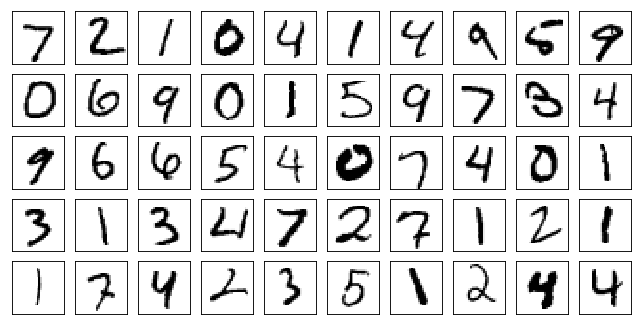

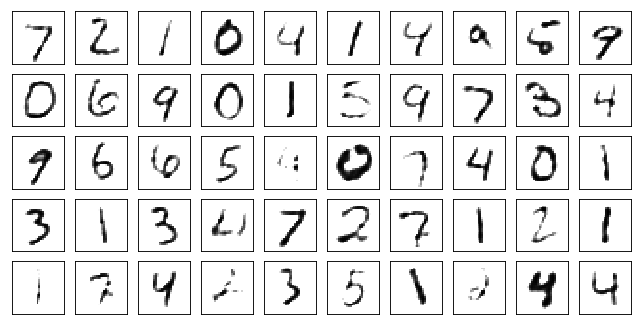

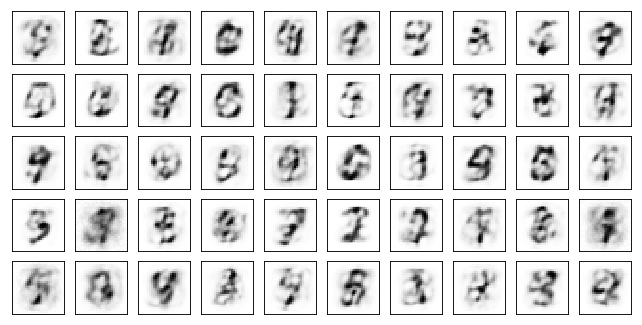

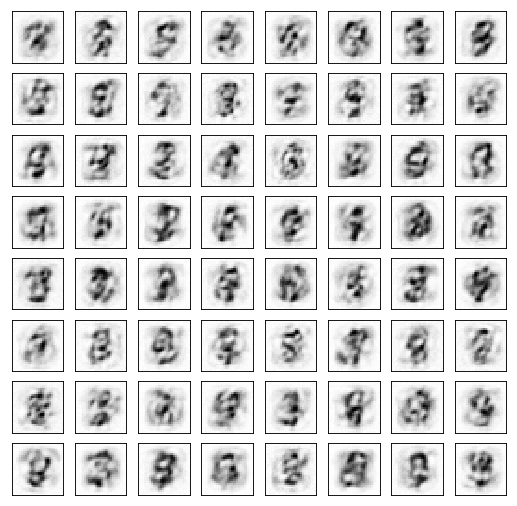

In [64]:
plot_mnist(data.data.cpu().numpy(), (5, 10))
plot_mnist(to_plot, (5, 10))
plot_mnist(f_to_plot, (5, 10))
plot_mnist(dec_to_plot, (8, 8))

**Conclusion**:   
- NN with tanh+L1 is better than NN with sigmoid+KL in terms of quality of the digits decoded from original data, but worse in terms of decoding with part of neurons (with activation > 0.5) and decoding eye matrix
- lambda parameter can be added for controlling tradeof between the loss and L1 penalty term

In [47]:
class Encoder3(nn.Module):
    def __init__(self, latent_size=10):
        super(Encoder3, self).__init__()
        self.fc1 = nn.Linear(28*28, latent_size)
    
    def forward(self, x):
        x = torch.sigmoid(self.fc1(x))
#         x = torch.tanh(self.fc1(x))
        return x
    
class Decoder3(nn.Module):
    def __init__(self, latent_size=10):
        super(Decoder3, self).__init__()
        self.fc1 = nn.Linear(latent_size, 28*28)
    
    def forward(self, x):
        x = torch.tanh(self.fc1(x))
        return x

In [56]:
# NN with sigmoid activation and rho_loss based on L1

class Net2(nn.Module):
    def __init__(self, latent_size=10, loss_fn=F.mse_loss, lr=1e-4, l2=0.):
        super(Net2, self).__init__()
        self.latent_size = latent_size
        self.E = Encoder2(latent_size)
        self.D = Decoder2(latent_size)
        self.loss_fn = loss_fn
        self._rho_loss = None
        self._loss = None
        self.optim = optim.Adam(self.parameters(), lr=lr, weight_decay=l2)
        
    def forward(self, x):
        x = x.view(-1, 28*28)
        h = self.E(x)
        self.data_rho = h.mean(0)
        out = self.D(h)
        return out
    
    def decode(self, h):
        with torch.no_grad():
            return self.D(h)
    
    def rho_loss(self, rho, size_average=True):
        """
        D_KL(P||Q) = sum(p*log(p/q)) = -sum(p*log(q/p)) = -p*log(q/p) - (1-p)log((1-q)/(1-p))
        """
        
        l1 = torch.abs(self.data_rho - rho)
            
        if size_average:
            self._rho_loss = l1.mean()
        else:
            self._rho_loss = l1.sum()
                    
        return self._rho_loss
    
    def loss(self, x, target, **kwargs):
        target = target.view(-1, 28*28)
        self._loss = self.loss_fn(x, target, **kwargs)
        return self._loss

In [57]:
models_2 = {'16': Net2(16).to(device), '32': Net2(32).to(device), '64': Net2(64).to(device)}
rho = 0.05
train_log = {k: [] for k in models}
test_log = {k: [] for k in models}

for epoch in range(1, 21):
    for model in models_2.values():
        model.train()
    train(epoch, models_2, train_log)
    for model in models_2.values():
        model.eval()
    test(models_2, valid_loader, test_log)

Train Epoch: 1 [0/50000 (0%)]	Losses 16: 1.011566 32: 1.013390 64: 1.032555
Train Epoch: 1 [10000/50000 (20%)]	Losses 16: 0.893201 32: 0.883170 64: 0.789830
Train Epoch: 1 [20000/50000 (40%)]	Losses 16: 0.853919 32: 0.827855 64: 0.518401
Train Epoch: 1 [30000/50000 (60%)]	Losses 16: 0.819177 32: 0.528421 64: 0.381280
Train Epoch: 1 [40000/50000 (80%)]	Losses 16: 0.752016 32: 0.402035 64: 0.325431
Train Epoch: 1 [50000/50000 (100%)]	Losses 16: 0.624827 32: 0.362053 64: 0.306454
Test set:
16: loss: 0.6235	rho_loss: 0.0015
32: loss: 0.3628	rho_loss: 0.0031
64: loss: 0.3069	rho_loss: 0.0025

Train Epoch: 2 [0/50000 (0%)]	Losses 16: 0.624275 32: 0.363205 64: 0.307665
Train Epoch: 2 [10000/50000 (20%)]	Losses 16: 0.501195 32: 0.339586 64: 0.290959
Train Epoch: 2 [20000/50000 (40%)]	Losses 16: 0.435345 32: 0.332349 64: 0.290879
Train Epoch: 2 [30000/50000 (60%)]	Losses 16: 0.381028 32: 0.306682 64: 0.266065
Train Epoch: 2 [40000/50000 (80%)]	Losses 16: 0.370655 32: 0.309369 64: 0.264061
Train

In [58]:
with torch.no_grad():
    data, _ = next(iter(test_loader))
    print(data.shape)
    data = data.to(device)
    
    # original data
    output = models_2['64'](data)
    to_plot = output.view(-1, 1, 28, 28).clamp(0, 1).data.cpu().numpy()
    
    # decoded eye matrix
    decoded = models_2['64'].decode(torch.eye(64).to(device))
    print(decoded.shape)
    dec_to_plot = ((decoded.view(-1, 1, 28, 28) + 1) * 0.5).clamp(0, 1).data.cpu().numpy()
    
    # encoded data with only neurons where activations > 0.5
    encoded = models_2['64'].E(data.view(-1, 28*28))
    print(encoded.shape)
    print((encoded > 0.5).sum(1))
    encoded[encoded < 0.5] = 0.
    
    # decoded data from previous step
    decoded_f = models_2['64'].decode(encoded)
    print(decoded_f.shape)
    f_to_plot = ((decoded_f.view(-1, 1, 28, 28) + 1) * 0.5).clamp(0, 1).data.cpu().numpy()

torch.Size([50, 1, 28, 28])
torch.Size([64, 784])
torch.Size([50, 64])
tensor([1, 4, 1, 3, 3, 1, 1, 2, 1, 3, 3, 1, 3, 3, 2, 1, 2, 1, 3, 2, 3, 3, 2, 1,
        1, 1, 2, 2, 2, 1, 3, 2, 2, 2, 3, 3, 2, 1, 0, 1, 1, 2, 1, 1, 2, 1, 1, 0,
        4, 1], device='cuda:0')
torch.Size([50, 784])


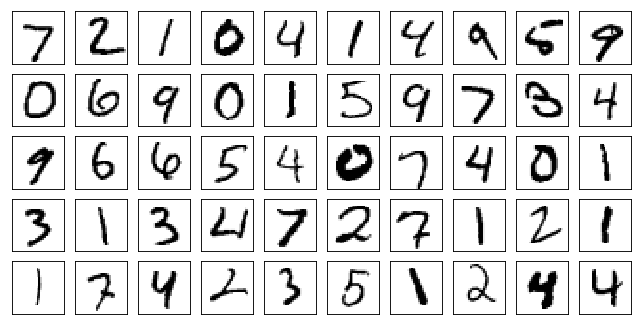

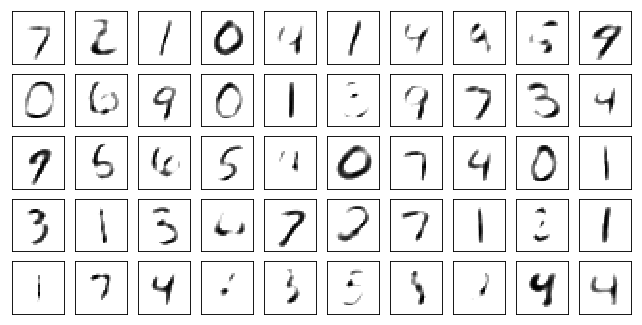

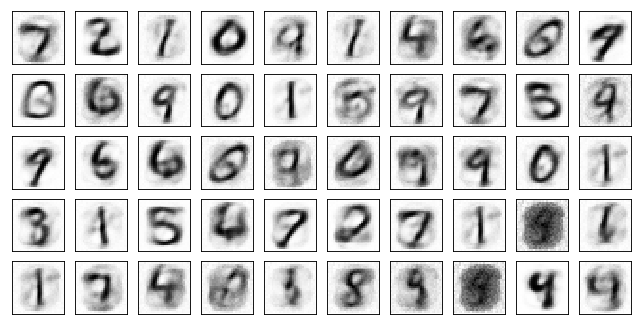

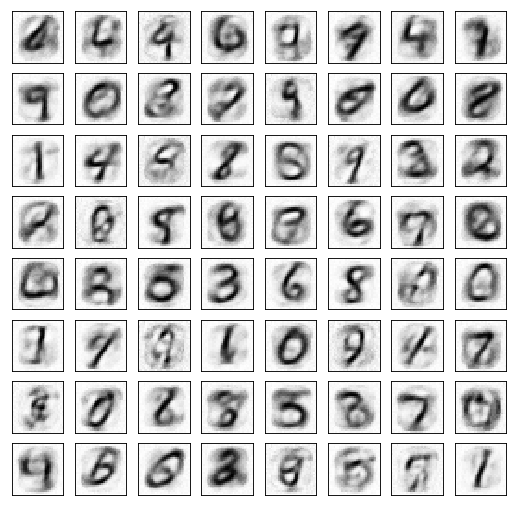

In [59]:
plot_mnist(data.data.cpu().numpy(), (5, 10))
plot_mnist(to_plot, (5, 10))
plot_mnist(f_to_plot, (5, 10))
plot_mnist(dec_to_plot, (8, 8))

**Conclusion**:   
- NN with tanh+L1 is slightly worse (in terms of quality of the digits) than NN with sigmoid+KL
- lambda parameter can be added for controlling tradeof between the loss and L1 penalty term